In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score


In [2]:
#Data 
data_path = './data/raw/train.csv'
t_data_path = './data/raw/test.csv'

df_train = pd.read_csv(data_path)
df_test = pd.read_csv(t_data_path)

Gathering information about the data.

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                5634 non-null   int64  
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5416 non-null   object 
 5   tenure            5173 non-null   float64
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   object 


In [4]:
df_train.describe()

,id,SeniorCitizen,tenure,MonthlyCharges,Churn
count,5634.000000,5634.000000,5173.000000,5634.000000,5634.000000
mean,3530.313454,0.158679,32.332882,64.626438,0.265353
std,2036.195109,0.365409,24.463607,30.021806,0.441560
min,1.000000,0.000000,0.000000,18.250000,0.000000
25%,1775.250000,0.000000,9.000000,35.462500,0.000000
50%,3525.500000,0.000000,29.000000,70.250000,0.000000
75%,5303.750000,0.000000,55.000000,89.800000,1.000000
max,7043.000000,1.000000,72.000000,118.750000,1.000000


In [5]:
df_train.shape

(5634, 21)

In [6]:
df_train.head()

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4030,Female,0,No,No,56.0,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,Two year,No,NaN,45.05,2560.1,0
1,6731,Male,0,Yes,Yes,NaN,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0
2,6479,Female,0,Yes,No,60.0,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.7,0
3,6861,Female,0,No,No,37.0,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1
4,3266,Male,0,Yes,Yes,29.0,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.8,1


Checking for missing values

In [7]:
df_train.isna().sum()

id                    0
gender                0
SeniorCitizen         0
Partner               0
Dependents          218
tenure              461
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
Contract              0
PaperlessBilling      0
PaymentMethod        99
MonthlyCharges        0
TotalCharges          0
Churn                 0
dtype: int64

Since there are missing values, it's interesting to check how much it represents for each respective column.

In [8]:
#To evaluate how much of the missing values represent from each respective columns
total = df_train.isnull().sum().sort_values(ascending=False)
percent_1 = df_train.isnull().sum()/df_train.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(3)

,Total,%
tenure,461,8.2
Dependents,218,3.9
PaymentMethod,99,1.8


As it seens, missing values are barely noticeable within the data. Still, some preprocessing will be made rather than just dropping the missing data.

Now, some analysis will be carried about the data and what insights can be obtained from it.

In [9]:
#Analysing Churn
df_train['Churn'].value_counts()

0    4139
1    1495
Name: Churn, dtype: int64

As it seens, it's a imbalanced dataset, since positive churn represents less than 30% of the total data, therefore this will be a imbalanced classification analysis. 

([<matplotlib.patches.Wedge at 0x1c3fc5474f0>,
 [Text(-0.8514340413015712, -0.7730200989061503, 'Not Cancelled'),
  Text(0.8144151699406335, 0.7394105293884916, 'Cancelled')],
 [Text(-0.4812453276921924, -0.43692440372956315, '73.46%'),
  Text(0.44422645633125457, 0.40331483421190445, '26.54%')])

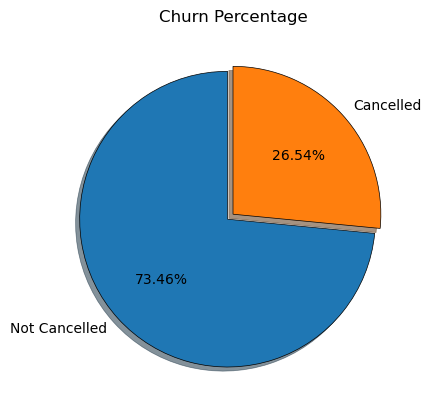

In [10]:
#Churn Percentage
churn_df = df_train['Churn'].value_counts()
churn_df = churn_df.set_axis(['Not Cancelled','Cancelled']) 
exp = [0.05,0.0]
plt.title('Churn Percentage')

plt.pie(churn_df, autopct = '%.02f%%',labels = churn_df.index, shadow = True, explode = exp,startangle= 90,wedgeprops = {'edgecolor':'black','linewidth':0.5,})

Checking for correlations.
First, analysing some categorical features that may enlight this analysis. 
For example, how's the churn related to:
* Having Phone Service and Multiple lines
* Having internet service, online security and backup
* Having Device protection and tech support
* Streaming TV and Movies
* Contract type
* Presence or absense of parents and dependents
* Being or not a senior citizen



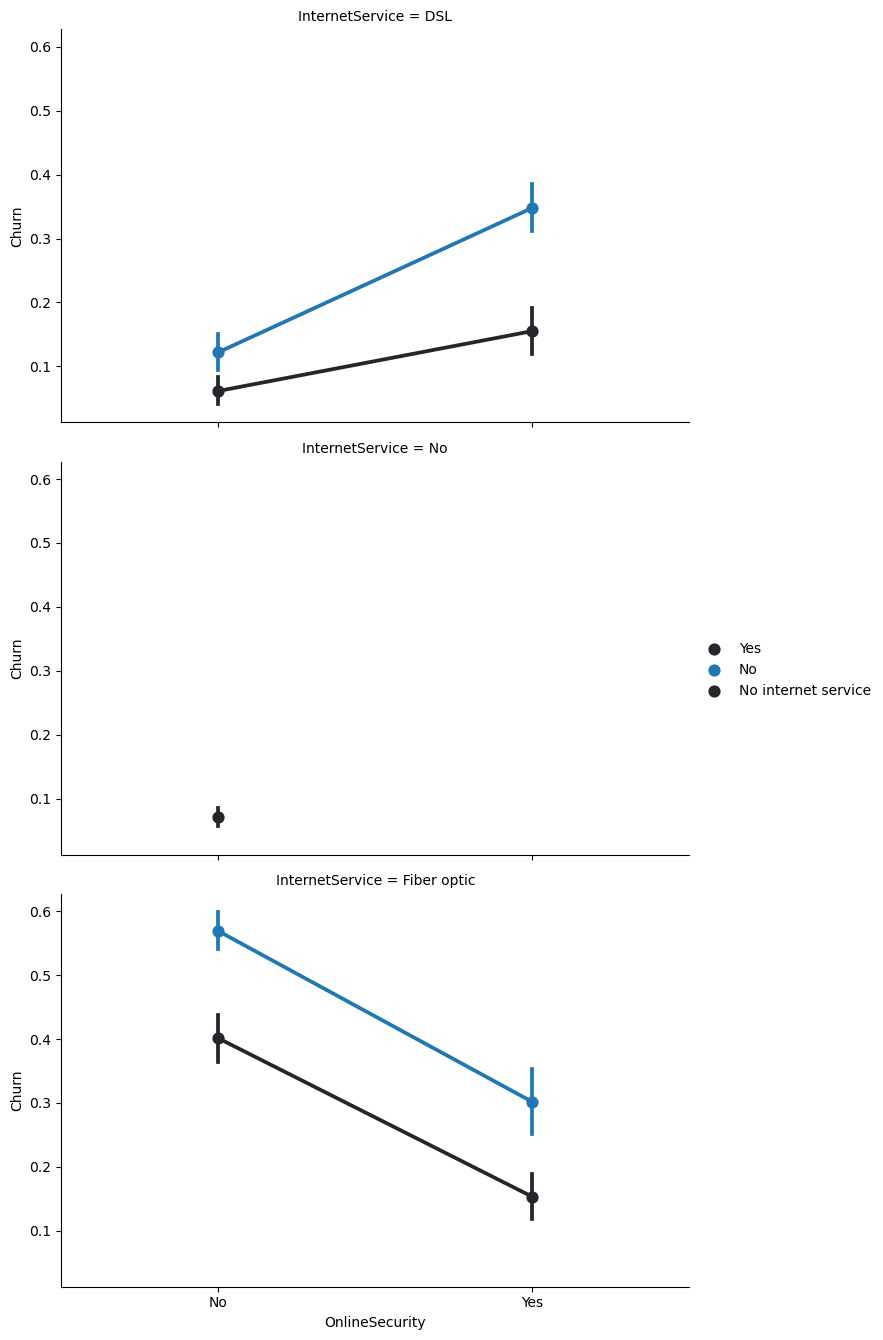

In [11]:
FacetGrid = sns.FacetGrid(df_train, row='InternetService', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot,  'OnlineSecurity','Churn','OnlineBackup' , order=None, hue_order=None )
FacetGrid.add_legend();

As it seens, there's a higher chance of Churn if it'a a DSL user with Online Security, but this is inverted with Fiber optic. Basically no churn occurs with no internet service.

Proceeding to deeper analysis based on monthly charges.

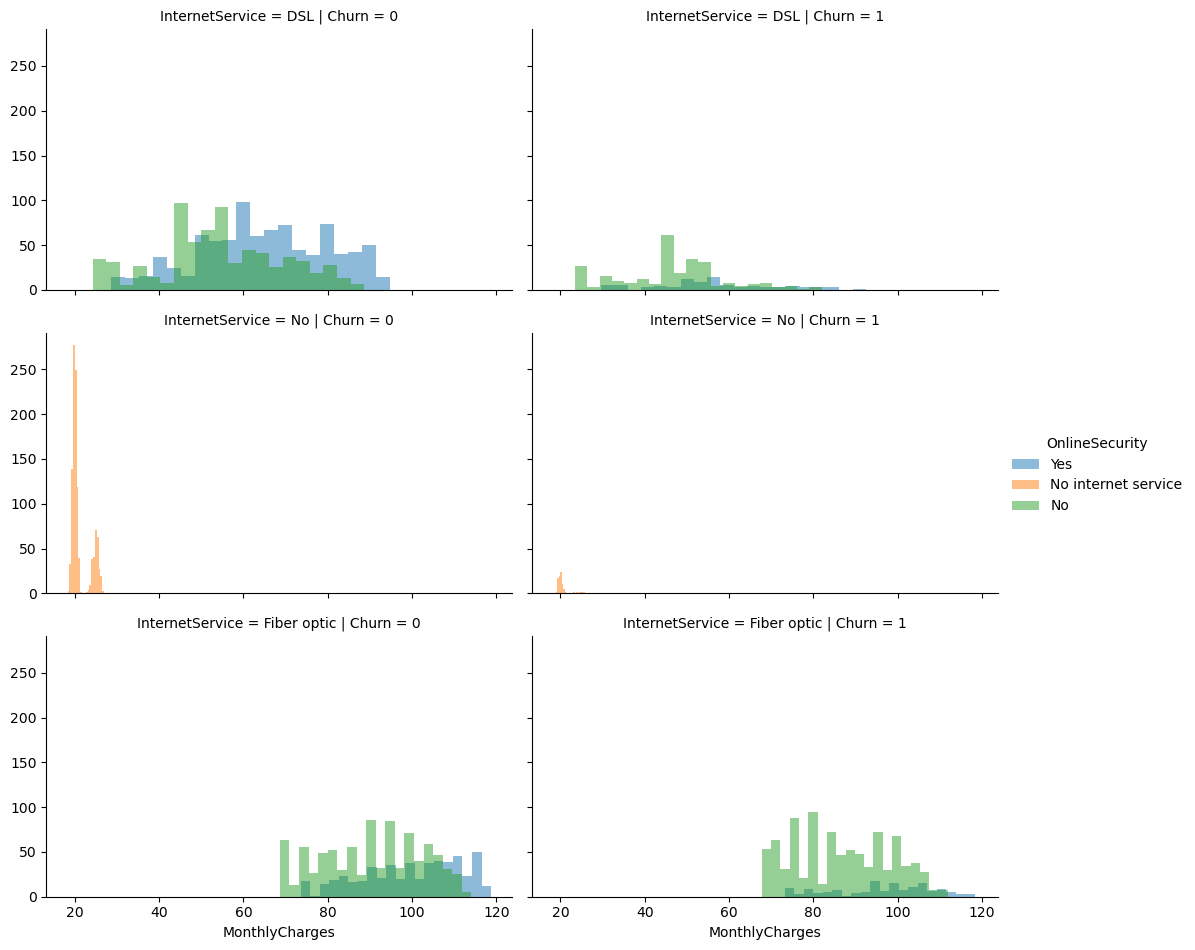

In [12]:
grid = sns.FacetGrid(df_train, col='Churn', row='InternetService', height=3.2, aspect=1.6, hue= 'OnlineSecurity')
grid.map(plt.hist, 'MonthlyCharges', alpha=.5, bins=20)
grid.add_legend();

It is interesting to see that higher churn occurs with Fiber optic on high monthly charges and mostly with Online Security service.

Following, relation between churn and contract type was analyzed.

In [13]:
df_train['Contract'].unique()

array(['Two year', 'One year', 'Month-to-month'], dtype=object)

<AxesSubplot:xlabel='Contract', ylabel='count'>

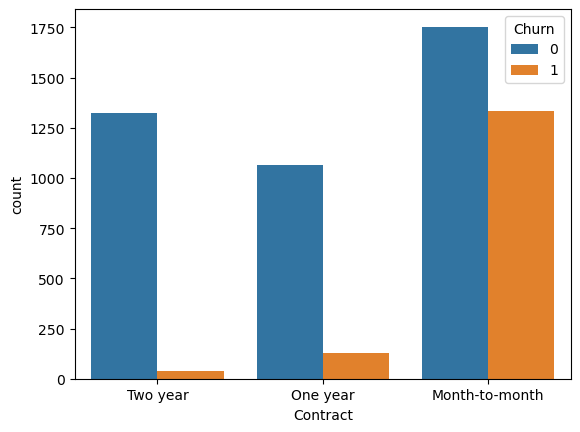

In [14]:
#Relation with contract
sns.countplot(x = 'Contract', data = df_train, hue = 'Churn')

<AxesSubplot:xlabel='Contract', ylabel='count'>

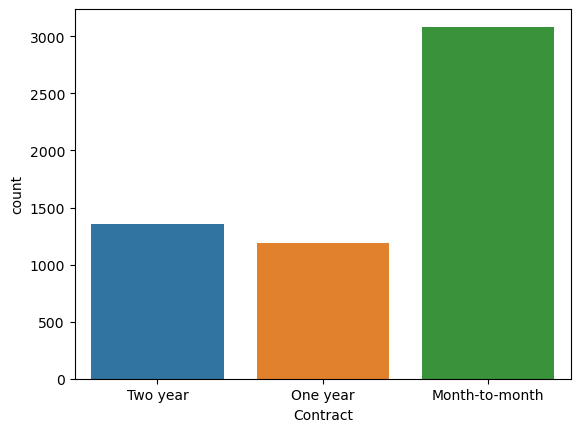

In [15]:
sns.countplot(x = 'Contract', data = df_train)

Month-to-month contracts are the highest in count, and also has a big churn among clients. It is interesting to contact clients with this contract type to offer discounts that could avoid these occurances.

Analyzing now the churn occurance relation with being a senior citizen.

<AxesSubplot:xlabel='SeniorCitizen', ylabel='count'>

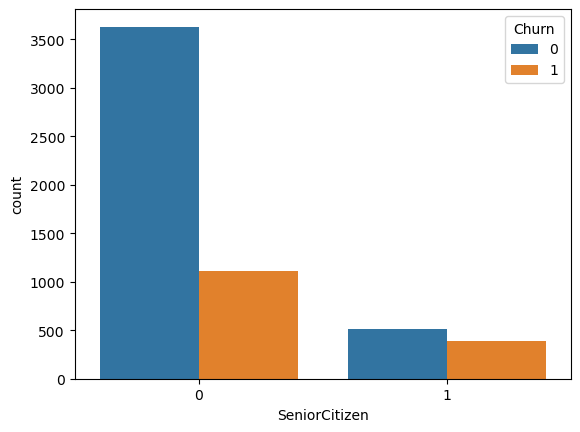

In [16]:
#Check if churn occurs more on senior citizens or not
sns.countplot(x = 'SeniorCitizen',data = df_train, hue = 'Churn')

([<matplotlib.patches.Wedge at 0x1c3fe9e10d0>,
 [Text(-1.1219328003092497, -0.25252087357334596, 'Not Cancelled'),
  Text(1.0731531133392822, 0.2415417051571134, 'Cancelled')],
 [Text(-0.6341359306095757, -0.1427291894110216, '57.05%'),
  Text(0.5853562436396084, 0.1317500209947891, '42.95%')])

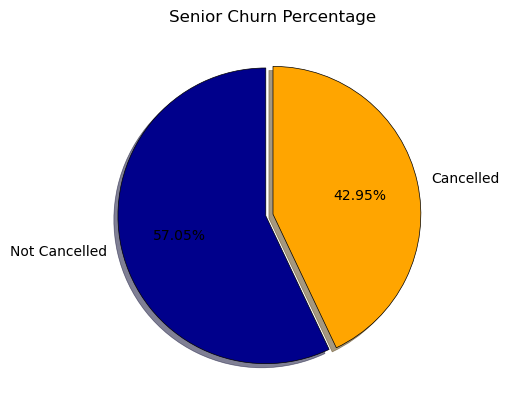

In [17]:
#Senior Churn Percentage
senior_pct = df_train.loc[(df_train['SeniorCitizen'] == 1), 'Churn'].value_counts()/df_train.loc[(df_train['SeniorCitizen'] == 1), 'Churn'].value_counts().sum()
senior_pct = senior_pct.set_axis(['Not Cancelled','Cancelled']) 
exp = [0.05,0.0]
plt.title('Senior Churn Percentage')

plt.pie(senior_pct, autopct = '%.02f%%',labels = senior_pct.index, shadow = True, explode = exp,startangle= 90,colors = ('darkblue','orange'),wedgeprops = {'edgecolor':'black','linewidth':0.5,})

Senior citizens are minority among clients of this company. Still, churn ocurred in almost 50% of senior citizen clients. It's important to see if a relation with contracted services exists.

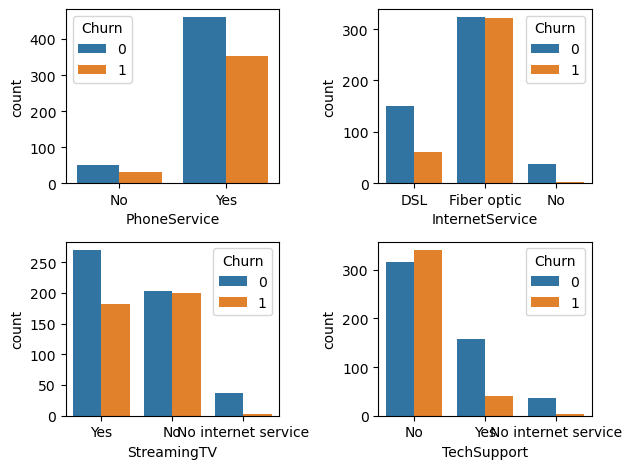

In [18]:
#What services does senior citizens use the most?
senior_df = df_train[df_train['SeniorCitizen'] == 1]
fig, axs = plt.subplots(ncols= 2, nrows = 2 )
sns.countplot(x = 'PhoneService', data = senior_df, hue = 'Churn', ax = axs[0][0])
sns.countplot(x = 'InternetService', data = senior_df, hue = 'Churn', ax = axs[0][1])
sns.countplot(x = 'StreamingTV', data = senior_df, hue = 'Churn', ax = axs[1][0])
sns.countplot(x = 'TechSupport', data = senior_df, hue = 'Churn', ax = axs[1][1])
plt.tight_layout()

Churn, as shown before, almost do not occur with costumers that decided for no internet service, and in this case for no phone service. The highest count occurs with costumers with No Tech Support. Since we're dealing with senior citizens, the absence of technical support can lead to difficulties with the use of services, what can motivate the service cancellation. 

The high churn among senior costumerss that doesn't have technical support brought a question in mind: is this a pattern over all clients? So, this analysis was done with a Categorical Plot.

Text(0.5, 0.98, 'Churn relation with Technical Support Service')

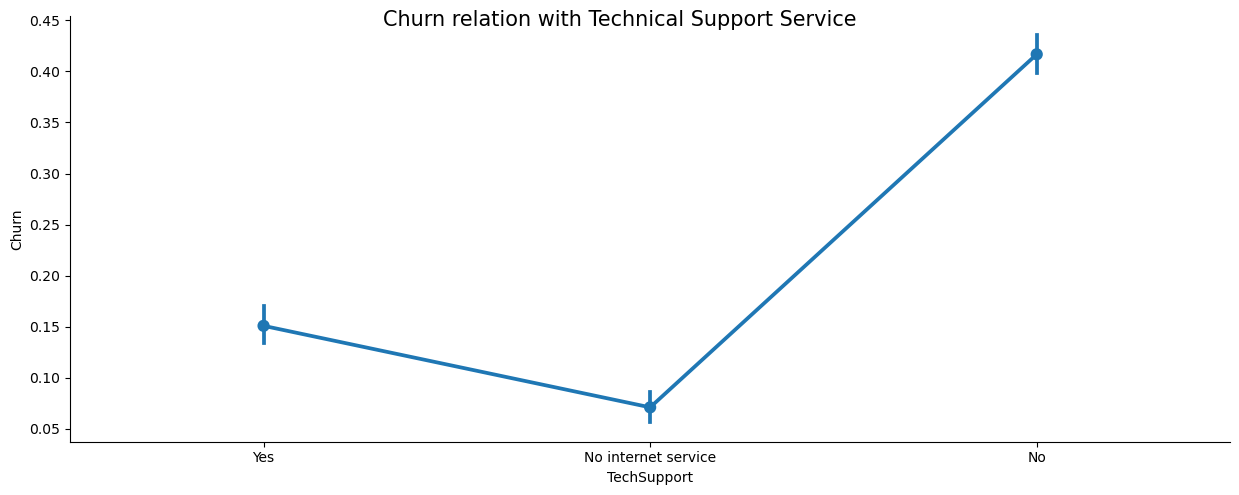

In [19]:
axes = sns.catplot(x = 'TechSupport',y = 'Churn', 
                      data=df_train, aspect = 2.5,kind = 'point');
axes.fig.suptitle('Churn relation with Technical Support Service',fontsize = 15)

The next analysis done was if there was any relation between churn and costumer having partners/dependents, which brought that clients with no partners/dependents are more inclined to churn.

After that, the last analysis was about streaming TV and movies, to check how many costumers decided for both services.


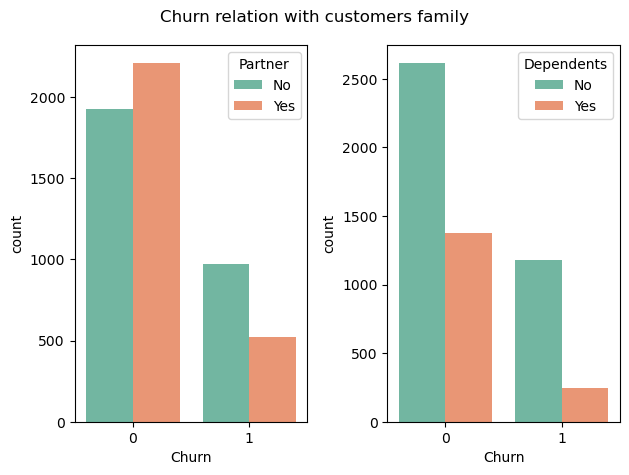

In [20]:

fig, axes = plt.subplots(ncols = 2)
sns.countplot(x = 'Churn', data = df_train, hue = 'Partner', ax = axes[0], palette='Set2')
sns.countplot(x = 'Churn', data = df_train, hue = 'Dependents', ax = axes[1],  palette='Set2')
fig.suptitle('Churn relation with customers family')
plt.tight_layout()


A new feature can be created to encompass if the costumer has a full family (partner and dependents) or not.

<AxesSubplot:title={'center':'Streaming Services'}, xlabel='StreamingTV', ylabel='count'>

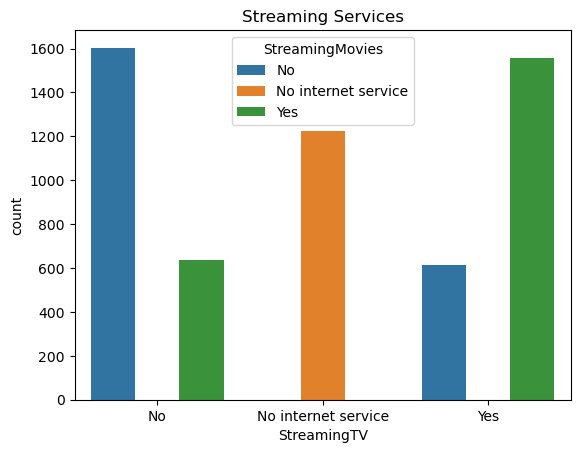

In [21]:
plt.title('Streaming Services')
sns.countplot(x = 'StreamingTV', data = df_train, hue = 'StreamingMovies')

As it seens, hardly someone who hires StreamingTV doesn't hire Streaming Movies, so a new feature can be created to encompass having both streaming services.

Now, the preprocessing of the data.

In [22]:
#Missing Values will be imputed by mode for categorical and mean for numerical values
dependents_mode = df_train['Dependents'].mode()
payment_mode = df_train['PaymentMethod'].mode()
tenure_mean = df_train['tenure'].mean()

In [23]:
df_train['Dependents'] = df_train['Dependents'].fillna(dependents_mode[0])
df_train['Dependents'].isna().sum()

0

In [24]:
df_train['PaymentMethod'] = df_train['PaymentMethod'].fillna(payment_mode[0])
df_train['PaymentMethod'].isna().sum()

0

In [25]:
df_train['tenure'] = df_train['tenure'].fillna(tenure_mean)
df_train['tenure'].isna().sum()

0

In [26]:
#Feature Engineering
#Creating a Full Family feature if Dependents and Partners are 1
df_train.loc[(df_train['Dependents'] == 'Yes') & (df_train['Partner'] == 'Yes'), 'Full_Family'] = 'Yes'
df_train.loc[(df_train['Partner'] == 'No') | \
             (df_train['Dependents'] == 'No') \
             ,'Full_Family'] = 'No'

In [27]:
df_train.head()

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Full_Family
0,4030,Female,0,No,No,56.000000,No,No phone service,DSL,Yes,...,Yes,No,No,Two year,No,Electronic check,45.05,2560.1,0,No
1,6731,Male,0,Yes,Yes,32.332882,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0,Yes
2,6479,Female,0,Yes,No,60.000000,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.7,0,No
3,6861,Female,0,No,No,37.000000,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1,No
4,3266,Male,0,Yes,Yes,29.000000,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.8,1,Yes


In [28]:
#Creating feature about full streaming service
df_train.loc[(df_train['StreamingTV'] == 'Yes') & (df_train['StreamingMovies'] == 'Yes'), 'Full_Streaming(TV/Movies)'] = 'Yes'
df_train.loc[((df_train['StreamingTV'] == 'Yes') & (df_train['StreamingMovies'] == 'No')) | \
             ((df_train['StreamingTV'] == 'No') & (df_train['StreamingMovies'] == 'Yes')) \
             | ((df_train['StreamingTV'] == 'No') & (df_train['StreamingMovies'] == 'No')) \
            | (df_train['StreamingTV'] == 'No internet service') | (df_train['StreamingMovies'] == 'No internet Service'),'Full_Streaming(TV/Movies)'] = 'No'


In [29]:
#New feature based on Monthly Charges and Tenure. On previous feature importance analysis not shown here, these two had the highest values, so a combination between those could led to a strong feature for the model.
df_train['Monthly_Tenure_Ratio'] = df_train['tenure']/df_train['MonthlyCharges']

In [30]:
df_train_n = df_train.drop(['StreamingTV','StreamingMovies','Dependents'],axis = 1)
df_train_n.head()

,id,gender,SeniorCitizen,Partner,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Full_Family,Full_Streaming(TV/Movies),Monthly_Tenure_Ratio
0,4030,Female,0,No,56.000000,No,No phone service,DSL,Yes,Yes,...,Yes,Two year,No,Electronic check,45.05,2560.1,0,No,No,1.243063
1,6731,Male,0,Yes,32.332882,Yes,No,No,No internet service,No internet service,...,No internet service,One year,No,Mailed check,19.65,332.65,0,Yes,No,1.645439
2,6479,Female,0,Yes,60.000000,Yes,Yes,Fiber optic,No,Yes,...,Yes,Two year,Yes,Credit card (automatic),110.80,6640.7,0,No,Yes,0.541516
3,6861,Female,0,No,37.000000,Yes,Yes,Fiber optic,No,Yes,...,No,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1,No,Yes,0.363101
4,3266,Male,0,Yes,29.000000,Yes,No,Fiber optic,No,No,...,No,Month-to-month,Yes,Electronic check,70.75,1974.8,1,Yes,No,0.409894


In [31]:
#Preprocessing - Binary and One-Hot Encoding features. Those which have only two categories (like gender) will be binary encoded.
X = df_train_n.copy()
y = X.pop('Churn')

columns = ['PhoneService','PaperlessBilling','Full_Family','Full_Streaming(TV/Movies)']
X['gender'] = X['gender'].replace({'Male': 0, 'Female':1})
for c in columns:
    X[c] = X[c].replace({'Yes': 0, 'No':1})
X.head()


,id,gender,SeniorCitizen,Partner,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Full_Family,Full_Streaming(TV/Movies),Monthly_Tenure_Ratio
0,4030,1,0,No,56.000000,1,No phone service,DSL,Yes,Yes,Yes,Yes,Two year,1,Electronic check,45.05,2560.1,1,1,1.243063
1,6731,0,0,Yes,32.332882,0,No,No,No internet service,No internet service,No internet service,No internet service,One year,1,Mailed check,19.65,332.65,0,1,1.645439
2,6479,1,0,Yes,60.000000,0,Yes,Fiber optic,No,Yes,Yes,Yes,Two year,0,Credit card (automatic),110.80,6640.7,1,0,0.541516
3,6861,1,0,No,37.000000,0,Yes,Fiber optic,No,Yes,Yes,No,Month-to-month,0,Bank transfer (automatic),101.90,3545.35,1,0,0.363101
4,3266,0,0,Yes,29.000000,0,No,Fiber optic,No,No,No,No,Month-to-month,0,Electronic check,70.75,1974.8,0,1,0.409894


Here starts the Machine Learning Algorithm preparation. At first, RandomForestClassifier was used, but after a comparing with LogisticRegression, the latter retrieved better results, being the chosen model. Then, a hyperparameter tuning was applied to improve the model performance.

In [32]:
#Data Split
X_train_full,X_valid_full,y_train,y_valid = train_test_split(X,y,test_size = 0.3,random_state=42)


In [33]:
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [34]:
#Applying One Hot Encoding
OHE = OneHotEncoder()

scaler = StandardScaler()

RFC = RandomForestClassifier(n_estimators = 100, min_samples_leaf= 2,min_samples_split= 2,max_features=0.35,random_state=42)
LGR = LogisticRegression(random_state = 42)

transformer = ColumnTransformer([('cat_cols', OHE, categorical_cols),
                                ('num_cols', scaler, numerical_cols)])

pipe = Pipeline([("preprocessing", transformer),
                ("classifier", LGR)])

pipe.fit(X_train, y_train)
pipe.score(X_train,y_train)


0.8095358863809282

In [35]:
preds = pipe.predict(X_valid)
acc = accuracy_score(preds,y_valid)
acc

0.8066232998225902

In [36]:
#Hyperparameter Tuning
grid = {'classifier__solver':['newton-cg', 'lbfgs', 'sag', 'saga'],'classifier__C':np.linspace(0.1,5,num = 10),'classifier__max_iter': range(1000,2500,250),
        'classifier__class_weight':[None,'balanced',0.25],
        'classifier__tol':[0.0001,0.01,0.1]
}
grid_search = GridSearchCV(estimator = pipe,param_grid = grid,cv = 5, return_train_score = True)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('cat_cols',
                                                                         OneHotEncoder(),
                                                                         ['Partner',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'Contract',
                             

In [37]:
grid_search.best_params_

{'classifier__C': 0.1,
 'classifier__class_weight': None,
 'classifier__max_iter': 1000,
 'classifier__solver': 'newton-cg',
 'classifier__tol': 0.0001}

In [38]:
grid_search.cv_results_['mean_train_score'].mean()

0.7916880031595227

In [39]:
tuned_LGR = LogisticRegression(solver= 'newton-cg',C = 0.1, class_weight = None, max_iter = 1000, tol = 0.0001,random_state = 42)
new_pipe = Pipeline([("preprocessing", transformer),
                ("classifier", tuned_LGR)])

new_pipe.fit(X_train, y_train)
new_pipe.score(X_train,y_train)


0.809789500380421

In [40]:
new_preds = new_pipe.predict(X_valid)
n_acc = accuracy_score(new_preds,y_valid)
n_acc

0.8066232998225902

Hyperparameter tuning until this moment didn't lead to any improvements over the results. Further analysis will be done to obtain higher scores.

Below, the information about the quality of the predition using classification report and confusion matrix.


In [41]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(y_valid,new_preds))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1257
           1       0.64      0.56      0.60       434

    accuracy                           0.81      1691
   macro avg       0.75      0.72      0.73      1691
weighted avg       0.80      0.81      0.80      1691



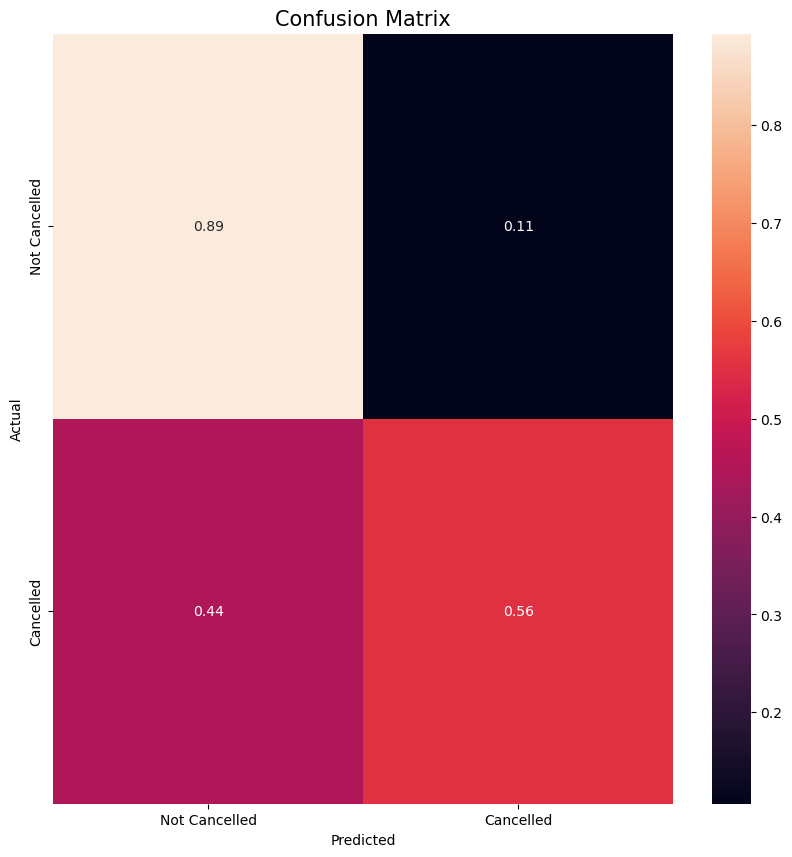

In [42]:
cm = confusion_matrix(y_valid, new_preds)
target_names = ['Not Cancelled','Cancelled']
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix', fontsize = 15)
plt.savefig('Confusion_Matrix.png')
plt.show(block=False)

In [43]:
rec = recall_score(y_valid, new_preds)
rec

0.5552995391705069

Since this is a imbalanced dataset, accuracy isn't the best metric for this case. As shown above, the model shown 55% of true positives for churn in the predictions, which means that over half of cancellations can be predicted and avoided. 

Below, is shown the feature importance of the dataset for the model.

In [44]:
ft_imp = pipe.steps[1][1].coef_[0]
#ft_imp_im = ft_imp.T.tolist()

In [45]:

encoded_cols = list(pipe['preprocessing'].transformers_[0][1].get_feature_names_out())



In [46]:
num_cols = list(pipe['preprocessing'].transformers_[1][1].get_feature_names_out())

In [47]:
total_cols = encoded_cols + num_cols

Feature_imp = pd.Series(ft_imp,index= total_cols)
Feature_imp = Feature_imp.sort_values(ascending = False)
Feature_imp

Contract_Month-to-month                    0.756106
InternetService_Fiber optic                0.485120
OnlineSecurity_No                          0.285360
TechSupport_No                             0.218216
PaymentMethod_Electronic check             0.192187
OnlineBackup_No                            0.157340
PhoneService                               0.140268
DeviceProtection_No                        0.098024
SeniorCitizen                              0.090696
id                                         0.064636
MultipleLines_Yes                          0.061975
Partner_No                                 0.057648
MonthlyCharges                             0.051297
MultipleLines_No phone service             0.040811
gender                                     0.021992
PaymentMethod_Bank transfer (automatic)    0.021326
Full_Family                                0.009789
DeviceProtection_Yes                      -0.024274
Contract_One year                         -0.028040
PaymentMetho

<AxesSubplot:title={'center':'Feature Importance'}>

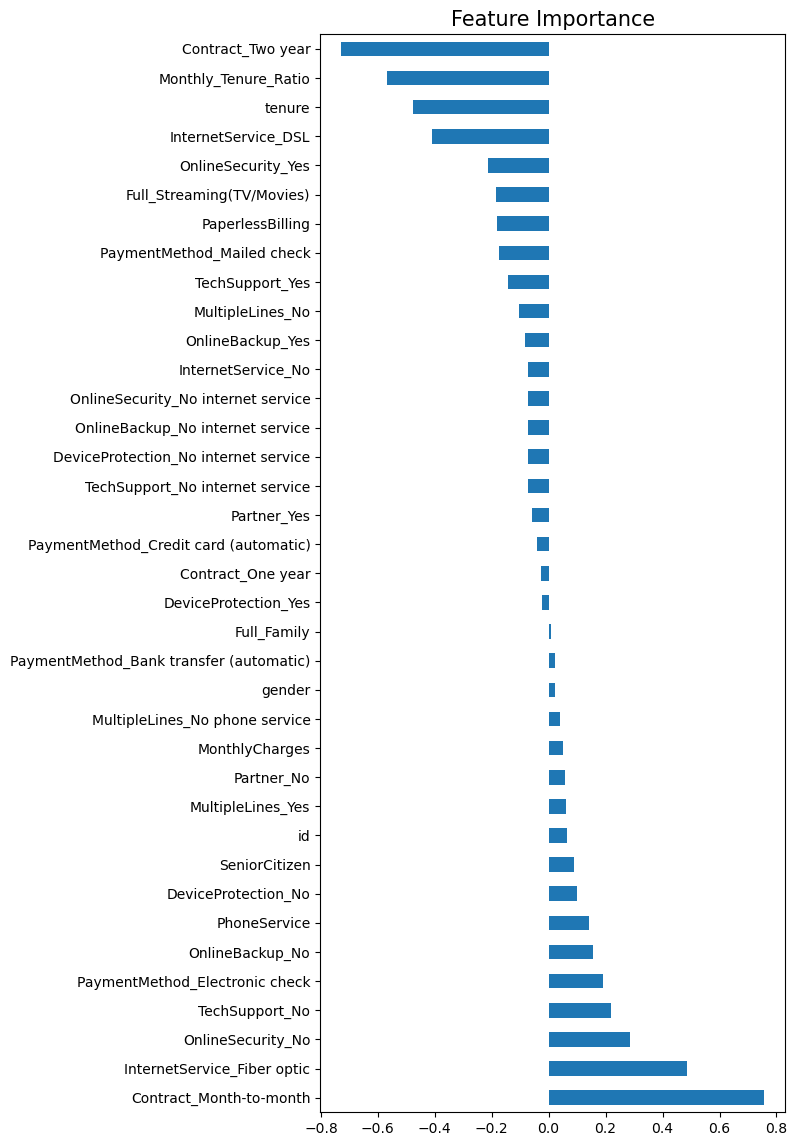

In [48]:
plt.figure(figsize = (6,14))
plt.title('Feature Importance',fontsize = 15)
Feature_imp.plot.barh()

With the model ready, the last step was the deployment to the service. The deploy was done using Pickle.

In [49]:
import pickle

pickle.dump(pipe, open('./models/modelo_churn.pkl', 'wb'))

The model was implemented in a application that will recieve information of a certain client, predicting if this costumer is a potential case of churn, in order to avoid and help the marketing team to contact and offer solutions so so that the customer's satisfaction with the company's service increases.